## Link a la presentación [aquí](https://youtu.be/lS_mRXTisYM)

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

## Path de las imágenes

In [ ]:
hojas_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/leaves'
sin_hojas_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/no_leaves'

In [ ]:
arch_hojas = os.listdir(hojas_dir)
arch_sin_hojas = os.listdir(sin_hojas_dir)

## Generación de imágenes nuevas

In [ ]:
def generador(dir, n):
  datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True)

  files = os.listdir(dir)
  for file in files:
    full_path = os.path.join(dir, file)

    if os.path.isdir(full_path):
        continue

    if file.endswith('.jpg') or file.endswith('.png'):
        img = Image.open(full_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1):

            save_img(os.path.join(dir, f'{file}_{i}.png'), batch[0])

            i += 1

            if i == n:
                break

### Se generan 50 versiones diferentes por cada una de las 8 imágenes originales que son de hojas de grama para hacer un total de 400 imágenes.

In [ ]:
generador(hojas_dir, 50)

### Se generan 100 versiones diferentes por cada una de las 4 imágenes originales que no son de hojas de grama para hacer un total de 400 imágenes.

In [ ]:
generador(sin_hojas_dir, 100)

## Se crea un modelo CNN para clasificar imágenes de grama

In [ ]:
images = []
labels = []

## Se transforman las imágenes y se asignan sus etiquetas

In [ ]:
for file in arch_hojas:
    full_path = os.path.join(hojas_dir, file)

    if file.endswith('.jpg') or file.endswith('.png'):
        img = Image.open(full_path)
        img_array = np.array(img)
        img_array = tf.image.rgb_to_grayscale(img_array)
        img_array = tf.image.resize(img_array, [500, 500])
        img_array = tf.image.per_image_standardization(img_array)
        images.append(img_array)

        label = 0
        labels.append(label)

for file in arch_sin_hojas:
    full_path = os.path.join(sin_hojas_dir, file)

    if file.endswith('.jpg') or file.endswith('.png'):
        img = Image.open(full_path)
        img_array = np.array(img)
        img_array = tf.image.rgb_to_grayscale(img_array)
        img_array = tf.image.resize(img_array, [500, 500])
        img_array = tf.image.per_image_standardization(img_array)
        images.append(img_array)

        label = 1
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

## Se crean los datasets de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

## Arquitectura del modelo

In [ ]:
modelo = Sequential()
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dropout(0.25))
modelo.add(Dense(2, activation='softmax'))

In [ ]:
modelo.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

## Entrenamiento y evaluación del modelo

In [ ]:
modelo.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test)
    )

Epoch 1/20
21/21 [==============================] - 16s 275ms/step - loss: 7.1381 - accuracy: 0.5513 - val_loss: 0.6746 - val_accuracy: 0.5000
Epoch 2/20
21/21 [==============================] - 4s 168ms/step - loss: 0.4941 - accuracy: 0.7703 - val_loss: 0.3663 - val_accuracy: 0.8293
Epoch 3/20
21/21 [==============================] - 4s 175ms/step - loss: 0.2022 - accuracy: 0.9142 - val_loss: 0.1576 - val_accuracy: 0.9329
Epoch 4/20
21/21 [==============================] - 4s 170ms/step - loss: 0.0514 - accuracy: 0.9877 - val_loss: 0.1051 - val_accuracy: 0.9512
Epoch 5/20
21/21 [==============================] - 4s 170ms/step - loss: 0.0296 - accuracy: 0.9908 - val_loss: 0.0944 - val_accuracy: 0.9573
Epoch 6/20
21/21 [==============================] - 4s 168ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0862 - val_accuracy: 0.9695
Epoch 7/20
21/21 [==============================] - 4s 175ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.1601 - val_accuracy: 0.9146
Epoch

In [ ]:
modelo.evaluate(X_test, y_test)

6/6 [==============================] - 0s 51ms/step - loss: 0.0688 - accuracy: 0.9878


[0.0688149482011795, 0.9878048896789551]

### Conteo de hojas

In [ ]:
def conteo(path):
  img = cv2.imread(path)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  bilateral_blur = cv2.bilateralFilter(gray,5,100,50)

  bordes = cv2.Canny(bilateral_blur, 0, 130,7)

  eroded_bilateral = cv2.erode(bordes, None, iterations =0)
  dilated_bilareal = cv2.dilate(eroded_bilateral, None, iterations=0)

  contours, _ = cv2.findContours(dilated_bilareal.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  #rect=0
  areas_cerradas = 0

  for cnt in contours:
      #x, y, w, h = cv2.boundingRect(cnt)
      area = cv2.contourArea(cnt)
      if 20 < area < 2000:
        #cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), 2)
        #rect += 1
        areas_cerradas += 1

  #hojas = len(contours)

  img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.drawContours(img_color, contours, -1, (255, 255, 255), 1)
  plt.imshow(img_color)
  print(f'Número de hojas de grama: {areas_cerradas}')

### Prueba del modelo con conteo de hojas

In [ ]:
def prueba(path):
  img = Image.open(path)
  img = np.array(img)
  img = tf.image.rgb_to_grayscale(img)
  img = tf.image.resize(img, [500, 500])
  img = tf.image.per_image_standardization(img)
  img = np.expand_dims(img, axis = 0)

  prediccion = modelo.predict(img)
  mejor_predict = np.argmax(prediccion[0])
  mejor_valor = round(np.max(prediccion[0])*100,4)
  predict_grama = (prediccion[0][0])*100
  etiquetas = ['es grama', 'no es grama']

  if predict_grama < 50:
    print(f'Con un {mejor_valor} de probabilidad, la imagen {etiquetas[mejor_predict]}.')
    imagen = tf.keras.preprocessing.image.load_img(path)
    plt.imshow(imagen)
    plt.axis('off')
    plt.show

  elif predict_grama >= 50:
    print(f'Con un {mejor_valor} de probabilidad, la imagen {etiquetas[mejor_predict]}.')
    conteo(path)


1/1 [==============================] - 0s 19ms/step
Con un 100.0 de probabilidad, la imagen no es grama.


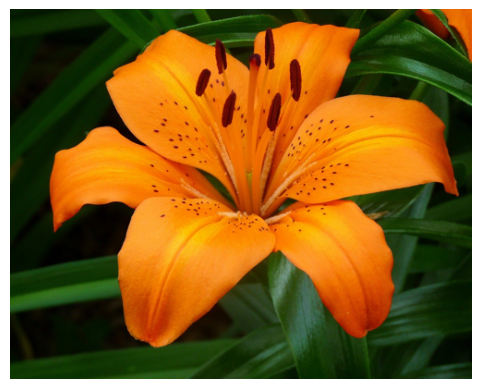

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/no_leaves/1_img4.png')

1/1 [==============================] - 0s 21ms/step
Con un 100.0 de probabilidad, la imagen es grama.
Número de hojas de grama: 38


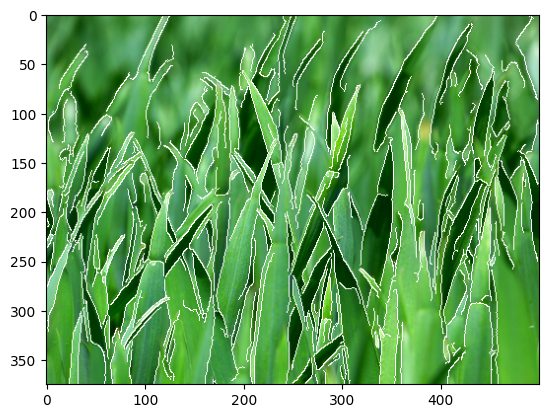

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/0_img4.png')

1/1 [==============================] - 0s 24ms/step
Con un 100.0 de probabilidad, la imagen es grama.
Número de hojas de grama: 275


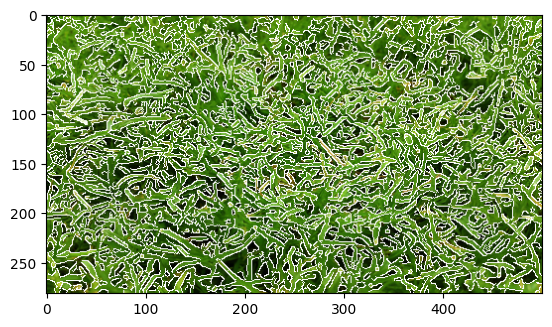

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/0_img8.png')

1/1 [==============================] - 0s 23ms/step
Con un 99.9975 de probabilidad, la imagen no es grama.


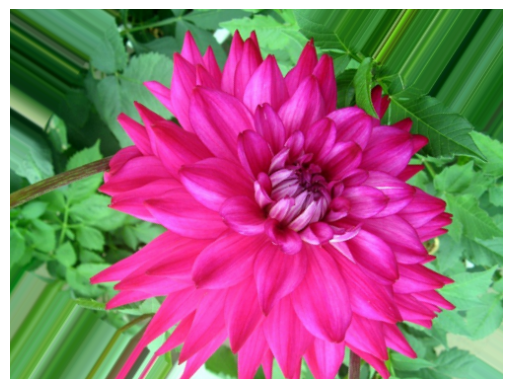

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/no_leaves/1_img3.png_38.png')

1/1 [==============================] - 0s 18ms/step
Con un 100.0 de probabilidad, la imagen es grama.
Número de hojas de grama: 1103


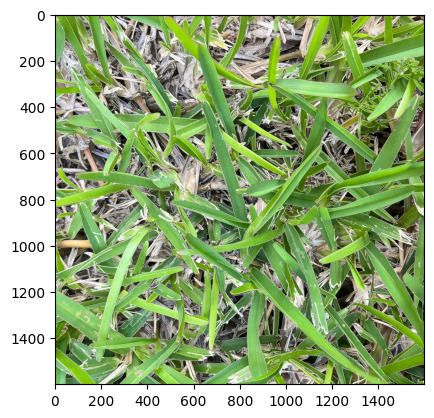

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/grass_image.jpg')

1/1 [==============================] - 0s 19ms/step
Con un 99.9676 de probabilidad, la imagen es grama.
Número de hojas de grama: 8


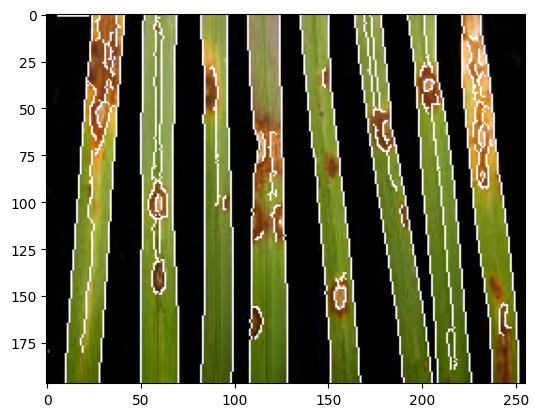

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/grass_image_2.jpg')

1/1 [==============================] - 0s 21ms/step
Con un 98.1262 de probabilidad, la imagen es grama.
Número de hojas de grama: 7


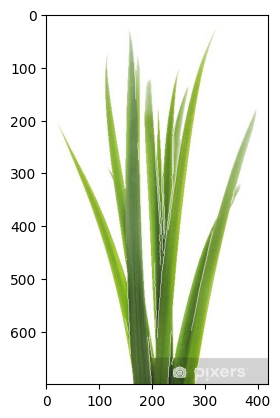

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/grass1.jpg')

1/1 [==============================] - 0s 18ms/step
Con un 100.0 de probabilidad, la imagen es grama.
Número de hojas de grama: 689


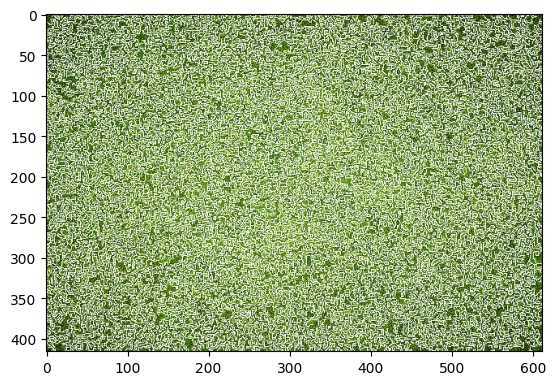

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/golf1.jpg')

1/1 [==============================] - 0s 29ms/step
Con un 100.0 de probabilidad, la imagen es grama.
Número de hojas de grama: 2919


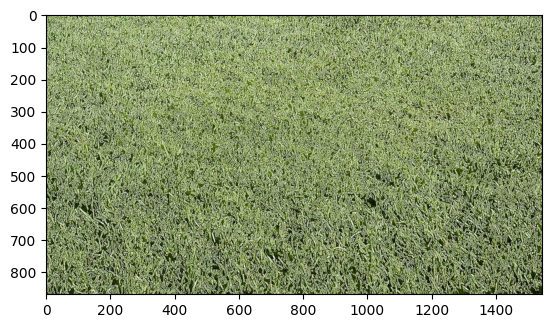

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/golf3.jpg')

1/1 [==============================] - 0s 28ms/step
Con un 100.0 de probabilidad, la imagen es grama.
Número de hojas de grama: 1575


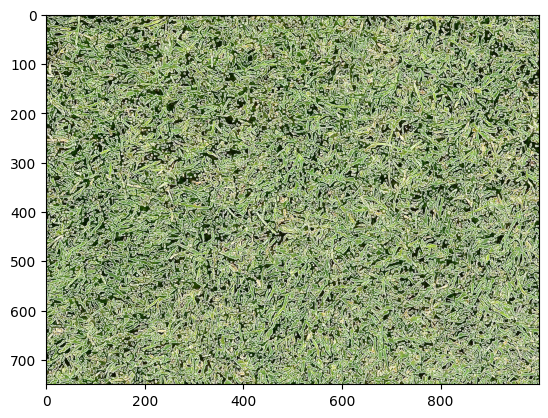

In [ ]:
prueba('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/golf2.JPG')

In [ ]:
def conteo2(path):
  img = cv2.imread(path)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  bilateral_blur = cv2.bilateralFilter(img,5,100,50)

  hsv_image = cv2.cvtColor(bilateral_blur, cv2.COLOR_BGR2HSV)
  lower_green = np.array([50, 40, 40])
  upper_green = np.array([80, 255, 255])
  green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
  green_highlight = cv2.bitwise_and(img, img, mask=green_mask)
  green_gray = cv2.cvtColor(green_highlight, cv2.COLOR_BGR2GRAY)

  bordes = cv2.Canny(green_gray, 0, 130,7)

  eroded_bilateral = cv2.erode(bordes, None, iterations =0)
  dilated_bilareal = cv2.dilate(eroded_bilateral, None, iterations=0)

  contours, _ = cv2.findContours(dilated_bilareal.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  #rect=0
  areas_cerradas = 0

  for cnt in contours:
      #x, y, w, h = cv2.boundingRect(cnt)
      area = cv2.contourArea(cnt)
      if 20 < area < 2000:
        #cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), 2)
        #rect += 1
        areas_cerradas += 1

  #hojas = len(contours)

  img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.drawContours(img_color, contours, -1, (255, 255, 255), 1)
  plt.imshow(img_color)
  print(f'Número de hojas de grama: {areas_cerradas}')

Número de hojas de grama: 98


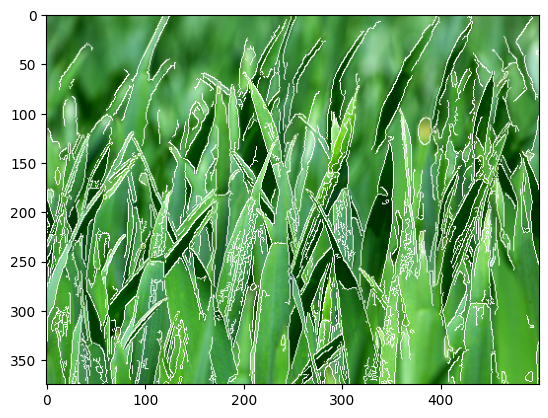

In [ ]:
conteo2('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/0_img4.png')

Número de hojas de grama: 202


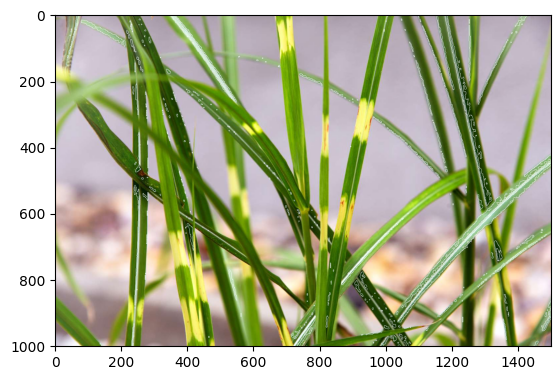

In [ ]:
conteo2('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/grass2.jpg')

Número de hojas de grama: 26


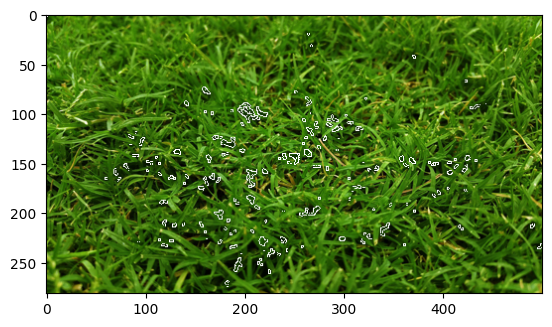

In [ ]:
conteo2('/content/drive/MyDrive/Colab Notebooks/dataset/leaves/0_img8.png')